In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LeakyReLU, Input
!pip install scikeras
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import make_scorer, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
import numpy as np

np.random.seed(528)
tf.random.set_seed(528)

df_1 = pd.read_csv('/content/sample_data/DSO528_project_spotify_1.csv')
df_2 = pd.read_csv('/content/sample_data/DSO528_project_spotify_2.csv')

df_1.head()

,track_id,track_name,track_artist,popular,release_year,release_month,playlist_genre,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,697MjF1454XKvZmTuqkWmD,I Miss You,Jeriqo,0,2019,2,edm,0.520,0.789,0,-7.717,1,0.0432,0.004910,0.000013,0.0816,0.415,174.026,216347
1,3x2bXiU0o4WbsPkawXlfDA,Who Are You,The Who,0,1978,8,rock,0.651,0.661,9,-11.405,1,0.0511,0.265000,0.003130,0.1060,0.489,156.371,378707
2,0jEaPBjFAWjQTMVouRwaHi,Happy,The Beef Seeds,0,2015,1,r&b,0.640,0.758,10,-5.204,1,0.1600,0.665000,0.000000,0.1270,0.932,86.529,218044
3,5EKUb1FKsyYVaSXb41YBIj,ONE,Rev Theory,0,2020,1,rock,0.398,0.966,4,-2.352,0,0.0453,0.000006,0.000000,0.3030,0.520,90.016,208196
4,300DUx4tdtCdGEUXR032jA,Palace/Curse,The Internet,0,2015,6,r&b,0.447,0.625,10,-8.212,0,0.3230,0.035100,0.000727,0.2430,0.261,67.104,440013


# Data research

In [ ]:
df_2.head()

,track_name,artist(s)_name,artist_count,released_year,released_month,released_day,streams,tempo,key,mode,danceability,valence,energy,acousticness,instrumentalness,liveness,speechiness
0,Seven (feat. Latto) (Explicit Ver.),"Latto, Jung Kook",2,2023,7,14,141381703,125,B,Major,0.80,0.89,0.83,0.31,0.00,0.08,0.04
1,LALA,Myke Towers,1,2023,3,23,133716286,92,C#,Major,0.71,0.61,0.74,0.07,0.00,0.10,0.04
2,vampire,Olivia Rodrigo,1,2023,6,30,140003974,138,F,Major,0.51,0.32,0.53,0.17,0.00,0.31,0.06
3,Cruel Summer,Taylor Swift,1,2019,8,23,800840817,170,A,Major,0.55,0.58,0.72,0.11,0.00,0.11,0.15
4,WHERE SHE GOES,Bad Bunny,1,2023,5,18,303236322,144,A,Minor,0.65,0.23,0.80,0.14,0.63,0.11,0.06


In [ ]:
merged_df = pd.merge(df_1, df_2,  how='inner', left_on=['track_name', 'track_artist'], right_on=['track_name', 'artist(s)_name'])
merged_df[[
    'danceability_x', 'danceability_y',
    'energy_x', 'energy_y',
    'key_x', 'key_y',
    'mode_x', 'mode_y',
    'speechiness_x', 'speechiness_y',
    'acousticness_x', 'acousticness_y',
    'instrumentalness_x', 'instrumentalness_y',
    'liveness_x', 'liveness_y',
    'valence_x', 'valence_y',
    'tempo_x', 'tempo_y'
    ]]


,danceability_x,danceability_y,energy_x,energy_y,key_x,key_y,mode_x,mode_y,speechiness_x,speechiness_y,acousticness_x,acousticness_y,instrumentalness_x,instrumentalness_y,liveness_x,liveness_y,valence_x,valence_y,tempo_x,tempo_y
0,0.505,0.33,0.710,0.71,3,D#,1,Major,0.0321,0.05,0.1900,0.20,0.000250,0.0,0.3290,0.28,0.428,0.38,89.938,180
1,0.578,0.58,0.669,0.67,10,A#,1,Major,0.0377,0.04,0.6500,0.65,0.000000,0.0,0.1300,0.13,0.503,0.46,75.995,76
2,0.544,0.54,0.552,0.55,9,A,1,Major,0.0991,0.11,0.6700,0.67,0.000046,0.0,0.4150,0.42,0.554,0.54,159.738,160
3,0.614,0.61,0.379,0.38,4,E,1,Major,0.0476,0.05,0.6070,0.61,0.000464,0.0,0.0986,0.10,0.201,0.20,107.989,108
4,0.776,0.77,0.780,0.78,10,A#,0,Minor,0.1280,0.11,0.0622,0.04,0.000000,0.0,0.0810,0.23,0.666,0.74,124.949,125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197,0.459,0.45,0.575,0.60,3,D#,1,Major,0.0573,0.06,0.6040,0.63,0.000000,0.0,0.0885,0.09,0.183,0.19,111.881,112
198,0.695,0.70,0.762,0.75,0,NaN,1,Major,0.0395,0.04,0.1920,0.24,0.002440,0.0,0.0863,0.09,0.553,0.59,120.042,120
199,0.648,0.65,0.785,0.80,7,G,1,Major,0.1650,0.16,0.0561,0.05,0.000000,0.0,0.1480,0.41,0.943,0.95,160.020,160
200,0.825,0.83,0.652,0.65,1,C#,0,Minor,0.0802,0.08,0.5810,0.58,0.000000,0.0,0.0931,0.09,0.931,0.93,95.977,96


Numeric columns like Energy, Sheechiness and etc. correspondent well between datasets. We can concat these tables.

In [ ]:
df_1[df_1['popular'] == 1].shape[0] / df_1.shape[0]

0.21792431279981725

# Data preparation

In [ ]:
def is_numerical(var):
    try:
        float(var)
        return True
    except (TypeError, ValueError):
        return False

def calculate_unix_timestamp_for_df_1(row):
    if is_numerical(row['release_year']) and is_numerical(row['release_month']):
        release_date = pd.to_datetime(str(row['release_year']) + '-' + str(row['release_month']) + '-15')
        return (release_date - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')
    elif is_numerical(row['release_year']):
        release_date = pd.to_datetime(str(row['release_year']) + '-07-15')
        return (release_date - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')
    else:
        return None

def calculate_unix_timestamp_for_df_2(row):
    if is_numerical(row['released_year']) and is_numerical(row['released_month']) and is_numerical(row['released_day']):
        release_date = pd.to_datetime(str(row['released_year']) + '-' + str(row['released_month']) + '-' + str(row['released_day']))
        return (release_date - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')
    elif is_numerical(row['released_year']) and is_numerical(row['released_month']):
        release_date = pd.to_datetime(str(row['released_year']) + '-' + str(row['released_month']) + '-15')
        return (release_date - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')
    elif is_numerical(row['released_year']) and not is_numerical(row['released_month']):
        release_date = pd.to_datetime(str(row['released_year']) + '-' + '-07-15')
        return (release_date - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')
    else:
        return None

df_1['unix_timestamp'] = df_1.apply(calculate_unix_timestamp_for_df_1, axis=1)
df_1 = df_1.drop(['release_year', 'release_month', 'track_id'], axis=1)

df_2['unix_timestamp'] = df_2.apply(calculate_unix_timestamp_for_df_2, axis=1)
df_2 = df_2.drop(['released_year', 'released_month', 'released_day'], axis=1)


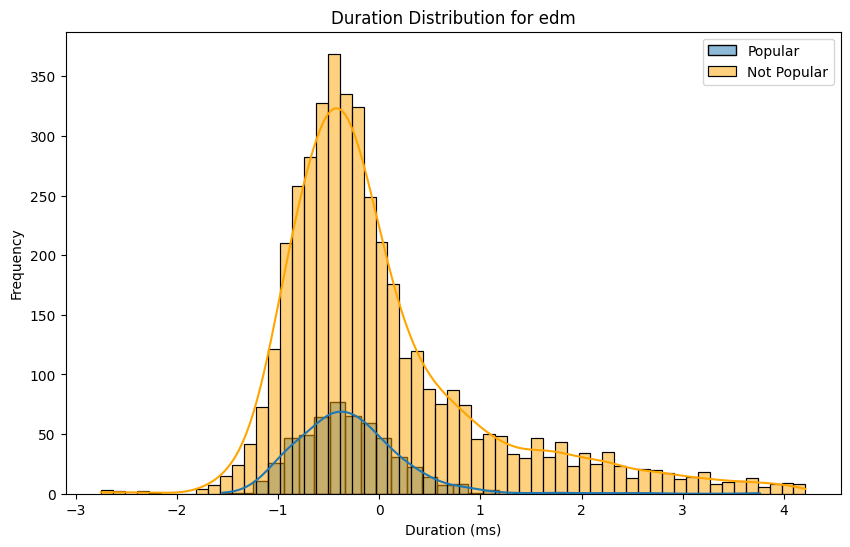

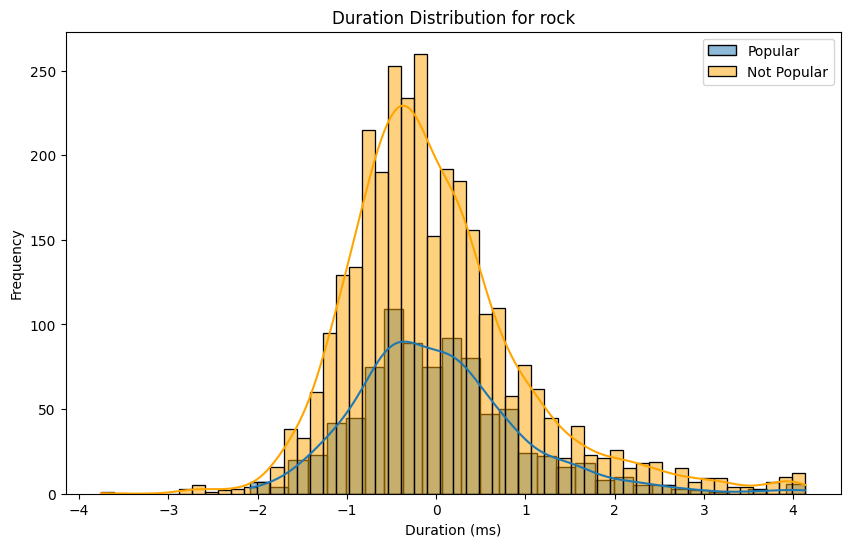

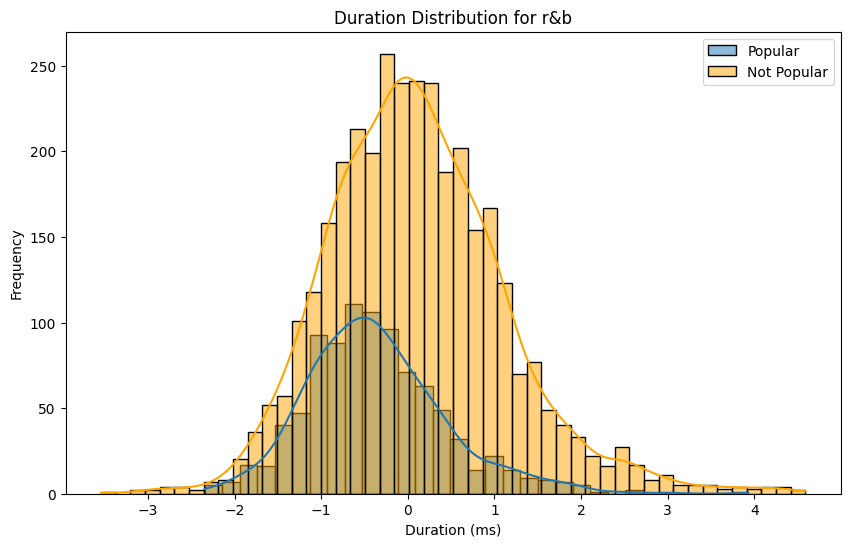

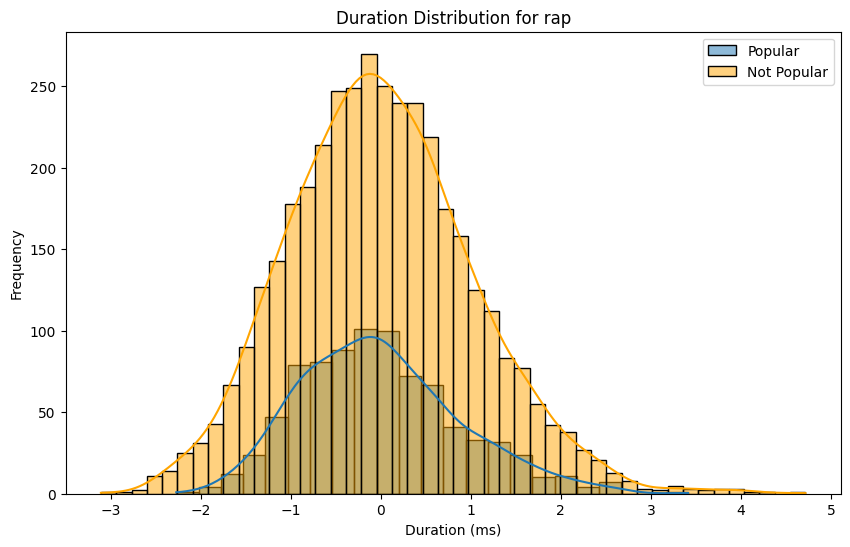

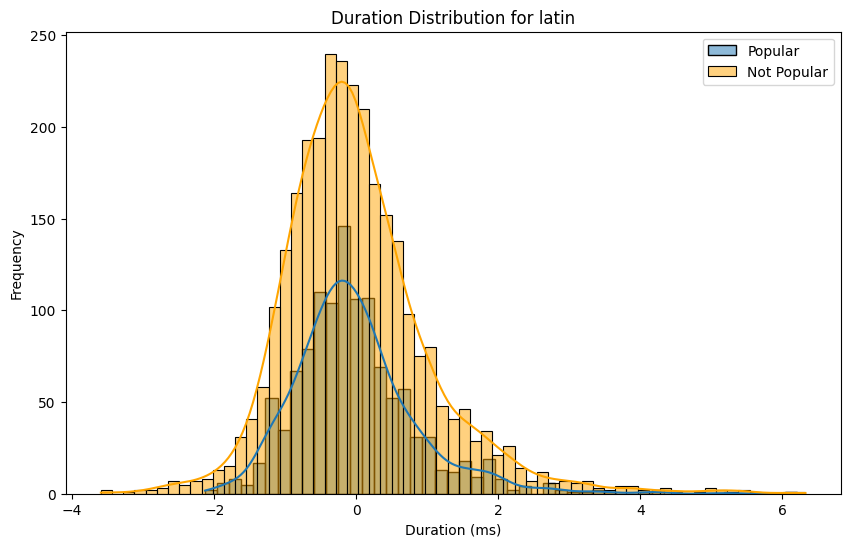

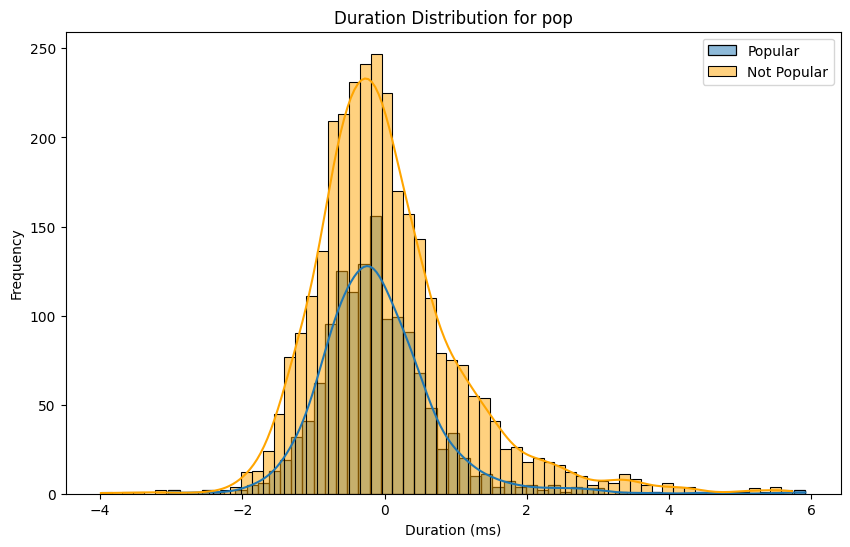

In [ ]:
for genre in df_1['playlist_genre'].unique():
    genre_df = df_1[df_1['playlist_genre'] == genre]
    plt.figure(figsize=(10, 6))

    sns.histplot((genre_df[genre_df['popular'] == 1]['duration_ms'] - genre_df['duration_ms'].mean()) / genre_df['duration_ms'].std(), label='Popular', kde=True)
    sns.histplot((genre_df[genre_df['popular'] == 0]['duration_ms'] - genre_df['duration_ms'].mean()) / genre_df['duration_ms'].std(), label='Not Popular', kde=True, color='orange')

    plt.title(f'Duration Distribution for {genre}')
    plt.xlabel('Duration (ms)')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

We can eyeball that, for some genres, durations differ. Hence we are going to keep this feature.

In [ ]:
df_2['popular'] = 1

key_mapping_1 = {
    "Major": 1, "Minor": 0
}
if df_2['mode'].dtype == 'object':
    df_2['mode'] = df_2['mode'].map(key_mapping_1)
key_mapping_2 = {
    "C": 0, "C#": 1, "Db": 1, "D": 2, "D#": 3, "Eb": 3, "E": 4, "F": 5, "F#": 6,
    "Gb": 6, "G": 7, "G#": 8, "Ab": 8, "A": 9, "A#": 10, "Bb": 10, "B": 11
}
if df_2['key'].dtype == 'object':
    df_2['key'] = df_2['key'].map(key_mapping_2)
df_2 = df_2.rename(columns={'artist(s)_name': 'track_artist'})
df_2 = df_2.drop(['artist_count'], axis=1)

df_1.loc[(df_1['unix_timestamp'] < 0) | (df_1['unix_timestamp'].isna()), 'unix_timestamp'] = (pd.Timestamp("1980-01-01") - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')
df_2.loc[(df_2['unix_timestamp'] < 0) | (df_2['unix_timestamp'].isna()), 'unix_timestamp'] = (pd.Timestamp("1980-01-01") - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')

In [ ]:
def preprocess_string(string):
    string = re.sub(r'[^\w]', '', str(string).lower())
    return ' '.join(string.split())

def generate_track_keys(track_name, track_artist):
    track_name_cleaned = preprocess_string(track_name)
    artists = [preprocess_string(artist) for artist in str(track_artist).split(',')] + [preprocess_string(track_artist)]
    return [f"{track_name_cleaned} {artist}" for artist in artists]

df_2_dict = {}
for idx, row in df_2.iterrows():
    track_keys = generate_track_keys(row['track_name'], row['track_artist'])
    for key in track_keys:
        df_2_dict[key] = row

updated_rows = []
for idx, row in df_1.iterrows():
    track_keys = generate_track_keys(row['track_name'], row['track_artist'])
    updated_row = row
    for key in track_keys:
        if key in df_2_dict:
            updated_row = df_2_dict[key]
            for col in df_1.columns:
                if col not in updated_row or pd.isna(updated_row[col]):
                    updated_row[col] = row[col]
            break
    updated_rows.append(updated_row)

enriched_df_1 = pd.DataFrame(updated_rows)

unique_keys_df_1 = set(df_1.apply(lambda row: preprocess_string(row['track_name']) + ' ' + preprocess_string(row['track_artist']), axis=1))
new_rows = [row for key, row in df_2_dict.items() if key not in unique_keys_df_1]

enriched_df_2 = pd.DataFrame(new_rows, columns=df_2.columns).drop_duplicates(subset=['track_name', 'track_artist'])

enriched_df = pd.concat([enriched_df_1, enriched_df_2], ignore_index=True)
enriched_df


,track_name,track_artist,popular,playlist_genre,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,unix_timestamp,streams
0,I Miss You,Jeriqo,0,edm,0.520,0.789,0.0,-7.717,1,0.0432,0.004910,0.000013,0.0816,0.415,174.026,216347.0,1.550189e+09,NaN
1,Who Are You,The Who,0,rock,0.651,0.661,9.0,-11.405,1,0.0511,0.265000,0.003130,0.1060,0.489,156.371,378707.0,2.719872e+08,NaN
2,Happy,The Beef Seeds,0,r&b,0.640,0.758,10.0,-5.204,1,0.1600,0.665000,0.000000,0.1270,0.932,86.529,218044.0,1.421280e+09,NaN
3,ONE,Rev Theory,0,rock,0.398,0.966,4.0,-2.352,0,0.0453,0.000006,0.000000,0.3030,0.520,90.016,208196.0,1.579046e+09,NaN
4,Palace/Curse,The Internet,0,r&b,0.447,0.625,10.0,-8.212,0,0.3230,0.035100,0.000727,0.2430,0.261,67.104,440013.0,1.434326e+09,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27132,My Mind & Me,Selena Gomez,1,NaN,0.600,0.390,9.0,NaN,1,0.0300,0.570000,0.000000,0.0800,0.240,144.000,NaN,1.667434e+09,91473363
27133,Bigger Than The Whole Sky,Taylor Swift,1,NaN,0.420,0.240,6.0,NaN,1,0.0600,0.830000,0.010000,0.1200,0.070,166.000,NaN,1.666310e+09,121871870
27134,A Veces (feat. Feid),"Feid, Paulo Londra",1,NaN,0.800,0.670,1.0,NaN,1,0.0600,0.040000,0.000000,0.0800,0.810,92.000,NaN,1.667434e+09,73513683
27135,En La De Ella,"Feid, Sech, Jhayco",1,NaN,0.820,0.770,1.0,NaN,1,0.0500,0.080000,0.000000,0.1200,0.670,97.000,NaN,1.666224e+09,133895612


In [ ]:
def preprocess_string(string):
    string = re.sub(r'[^\w]', '', str(string).lower())
    return ' '.join(string.split())

enriched_df['composed_key'] = enriched_df.apply(lambda x: preprocess_string(x['track_name']) + ' ' + preprocess_string(x['track_artist']), axis=1)

def aggregate_playlist_genres(group):
    best_row = group.sort_values(by='popular', ascending=False).iloc[0]
    unique_genres = ','.join([str(x) for x in group['playlist_genre'].unique() if len(str(x))])
    best_row['playlist_genre'] = unique_genres
    return best_row

df_cleaned = enriched_df.groupby('composed_key').apply(aggregate_playlist_genres).reset_index(drop=True)

df_cleaned.drop(columns=['composed_key'], inplace=True)
df_cleaned.drop(columns=['track_name', 'track_artist'], inplace=True)

df_cleaned


<ipython-input-9-6d3031c61323>:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_cleaned = enriched_df.groupby('composed_key').apply(aggregate_playlist_genres).reset_index(drop=True)


,popular,playlist_genre,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,unix_timestamp,streams
0,1,"pop,latin",0.561,0.666,8.0,-4.243,1,0.0322,0.1060,0.000000,0.1230,0.675,160.019,219367.0,1.576368e+09,NaN
1,1,nan,0.600,0.760,6.0,NaN,0,0.0500,0.1700,0.000000,0.1900,0.520,158.000,NaN,1.589933e+09,403097450
2,0,rap,0.532,0.629,10.0,-7.955,0,0.3710,0.2600,0.000000,0.4780,0.545,94.030,188893.0,1.302826e+09,NaN
3,1,nan,0.570,0.940,1.0,NaN,1,0.0900,0.1100,0.000000,0.3700,0.840,166.000,NaN,1.681258e+09,143573775
4,0,edm,0.804,0.846,6.0,-7.994,1,0.0565,0.0960,0.246000,0.0623,0.887,124.003,347187.0,1.539562e+09,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22408,0,r&b,0.473,0.973,9.0,-3.378,1,0.1700,0.2340,0.000051,0.4000,0.847,119.810,196093.0,1.529021e+09,NaN
22409,0,edm,0.429,0.724,3.0,-4.144,0,0.2000,0.8550,0.000000,0.1960,0.377,82.199,150178.0,1.539562e+09,NaN
22410,0,edm,0.498,0.917,5.0,-1.797,0,0.1640,0.0615,0.000000,0.3580,0.652,112.357,205612.0,1.408061e+09,NaN
22411,1,pop,0.839,0.902,1.0,-3.612,0,0.0536,0.0868,0.002570,0.2720,0.639,114.953,189050.0,1.510704e+09,NaN


See no sence in streams column from df_2. Dropping.

In [ ]:
df_cleaned.drop(columns=['streams'], inplace=True)

In [ ]:
df_cleaned['duration_ms'] = df_cleaned['duration_ms'].fillna(df_cleaned[df_cleaned['popular'] == 1]['duration_ms'].mean())
df_cleaned['loudness'] = df_cleaned['loudness'].fillna(df_cleaned[df_cleaned['popular'] == 1]['loudness'].mean())
df_cleaned['key'] = df_cleaned['key'].fillna(int(df_cleaned[df_cleaned['popular'] == 1]['key'].mean()))
df_cleaned['playlist_genre'] = df_cleaned['playlist_genre'].fillna('ambiguous')

In [ ]:
le = LabelEncoder()

df_cleaned['playlist_genre'] = df_cleaned['playlist_genre'].str.replace(r'.*,.*', 'ambiguous', regex=True)
df_cleaned['playlist_genre'] = le.fit_transform(df_cleaned['playlist_genre'])

df_cleaned = df_cleaned[df_cleaned['duration_ms'] >= 10000]

In [ ]:
df_cleaned.head()

,popular,playlist_genre,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,unix_timestamp
0,1,0,0.561,0.666,8.0,-4.243000,1,0.0322,0.106,0.000,0.1230,0.675,160.019,219367.000000,1.576368e+09
1,1,3,0.600,0.760,6.0,-6.349136,0,0.0500,0.170,0.000,0.1900,0.520,158.000,219879.274488,1.589933e+09
2,0,6,0.532,0.629,10.0,-7.955000,0,0.3710,0.260,0.000,0.4780,0.545,94.030,188893.000000,1.302826e+09
3,1,3,0.570,0.940,1.0,-6.349136,1,0.0900,0.110,0.000,0.3700,0.840,166.000,219879.274488,1.681258e+09
4,0,1,0.804,0.846,6.0,-7.994000,1,0.0565,0.096,0.246,0.0623,0.887,124.003,347187.000000,1.539562e+09


# Data experiments

In [ ]:
# df_cleaned = df_cleaned[df_cleaned['unix_timestamp'] >= (pd.Timestamp("1990-01-01") - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')]

# Fixing data skewness

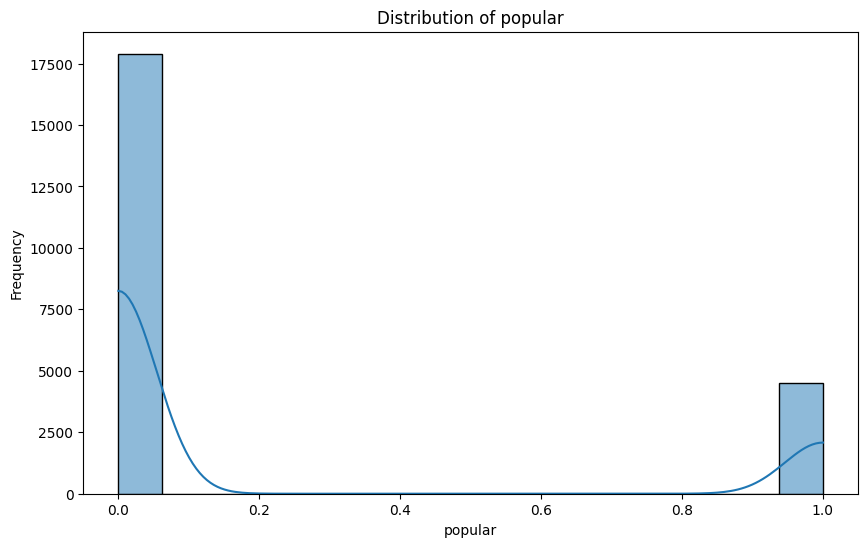

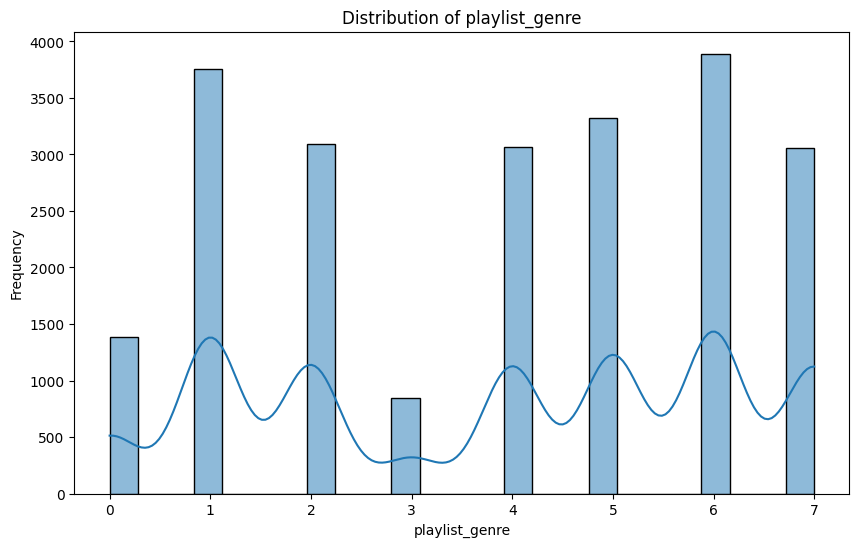

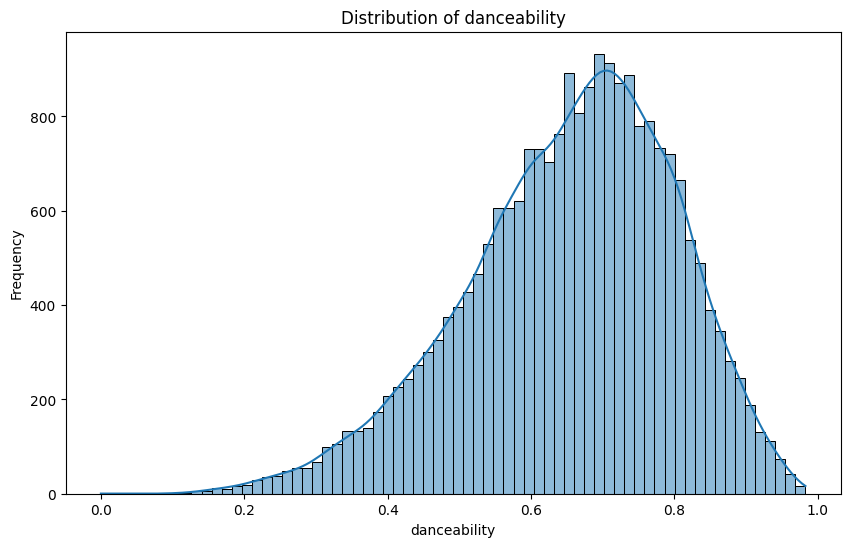

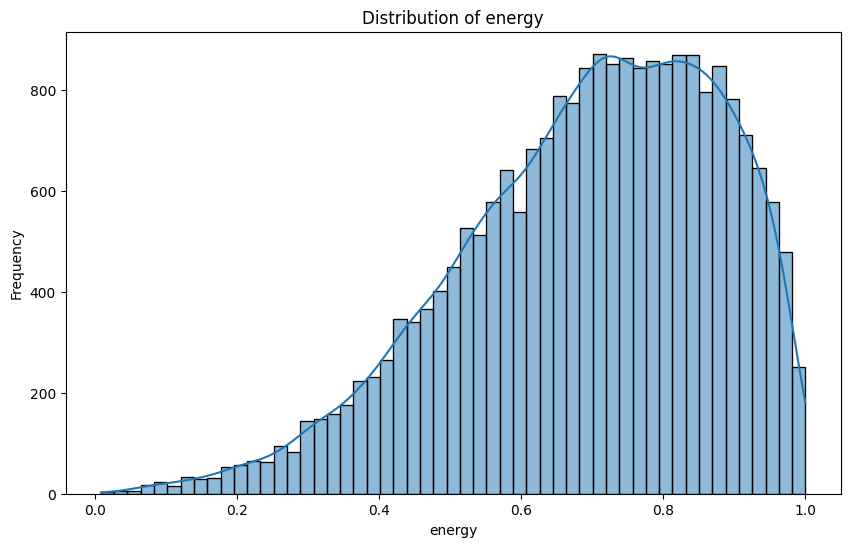

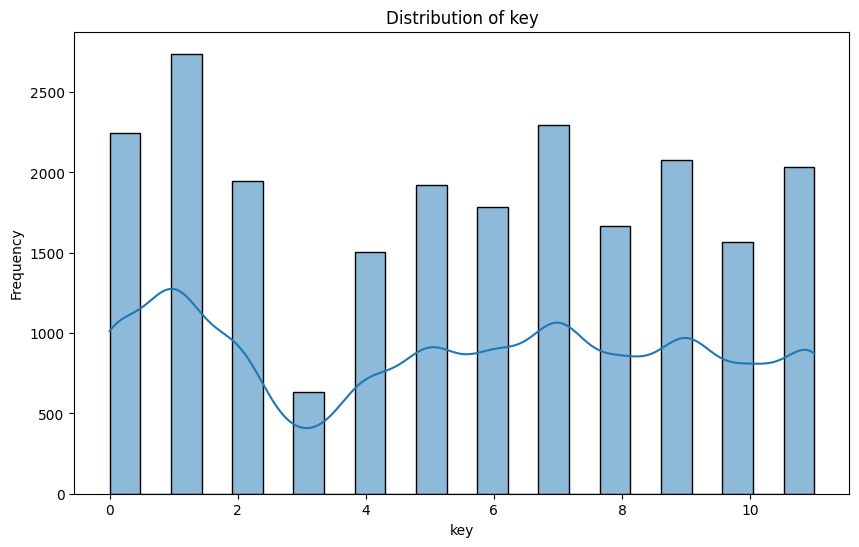

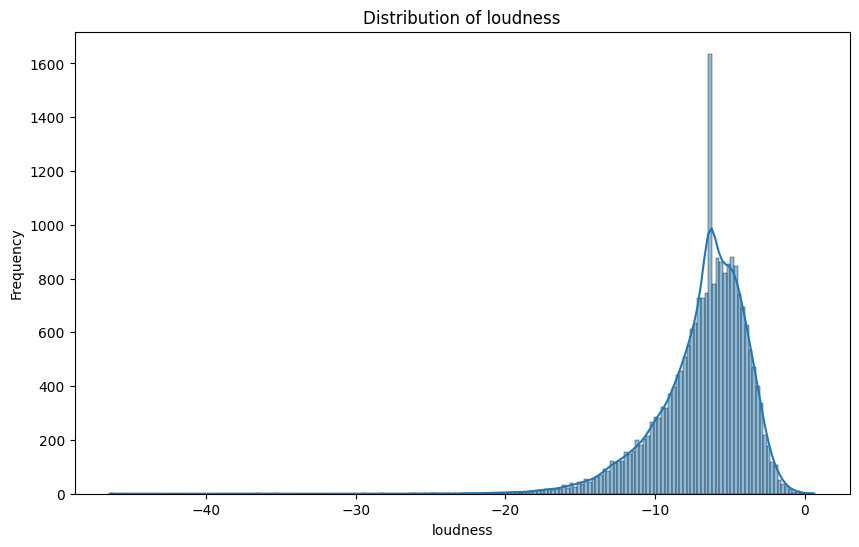

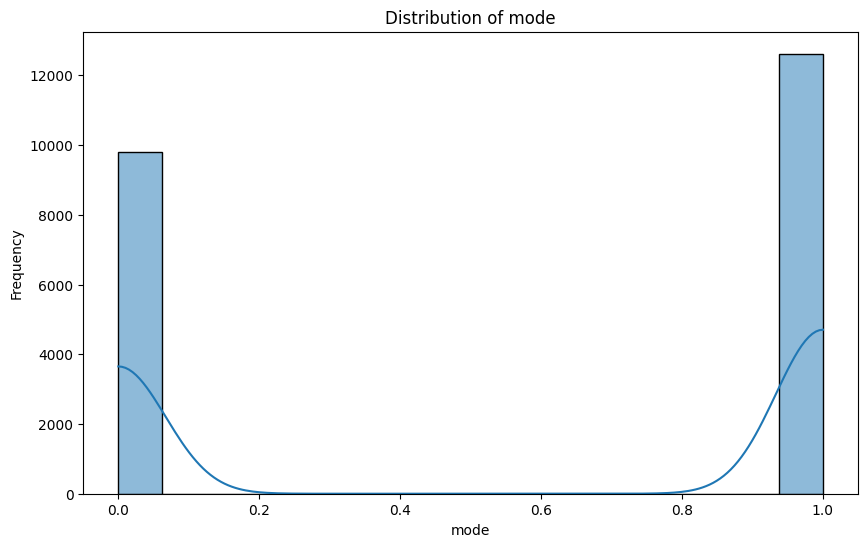

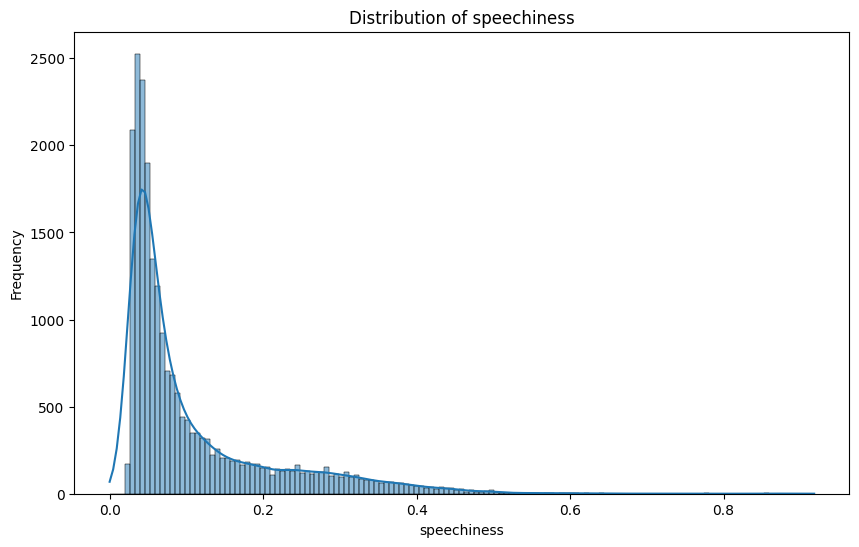

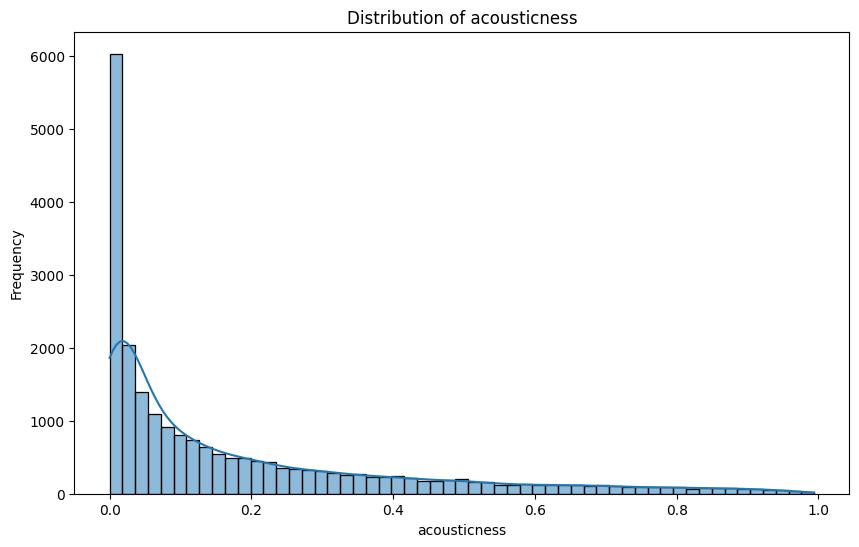

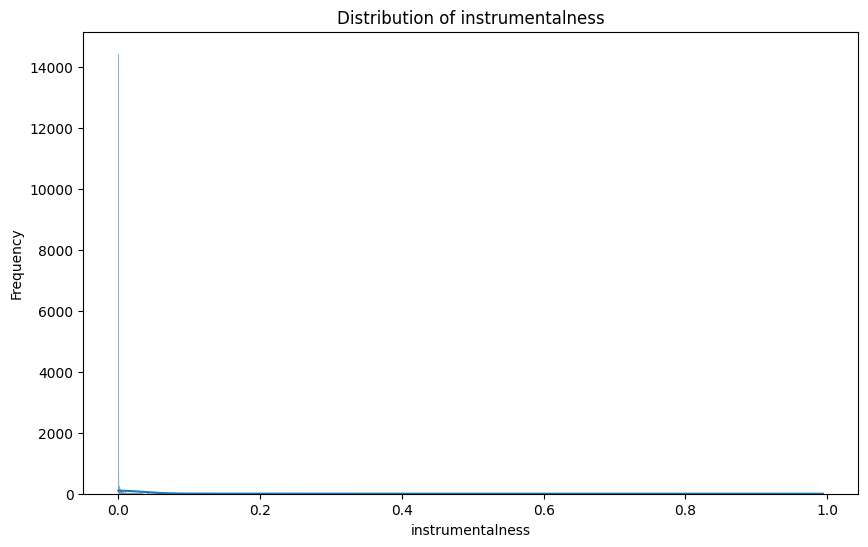

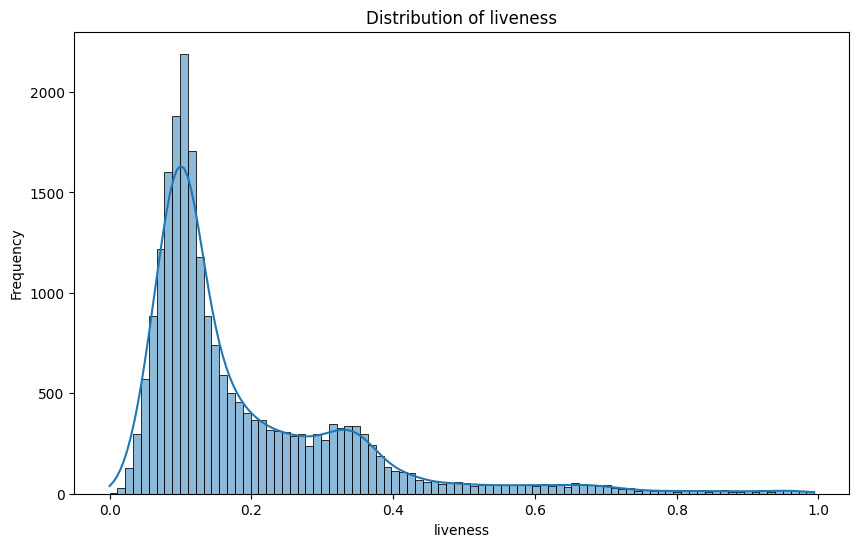

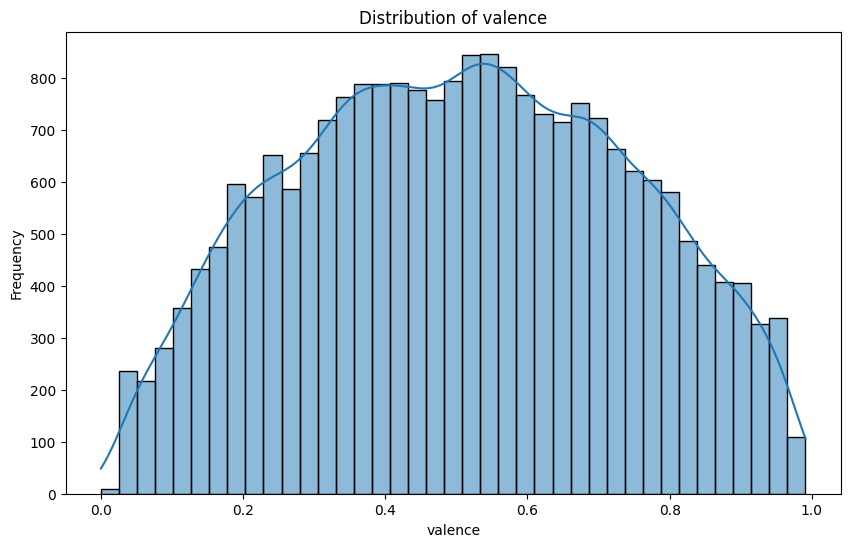

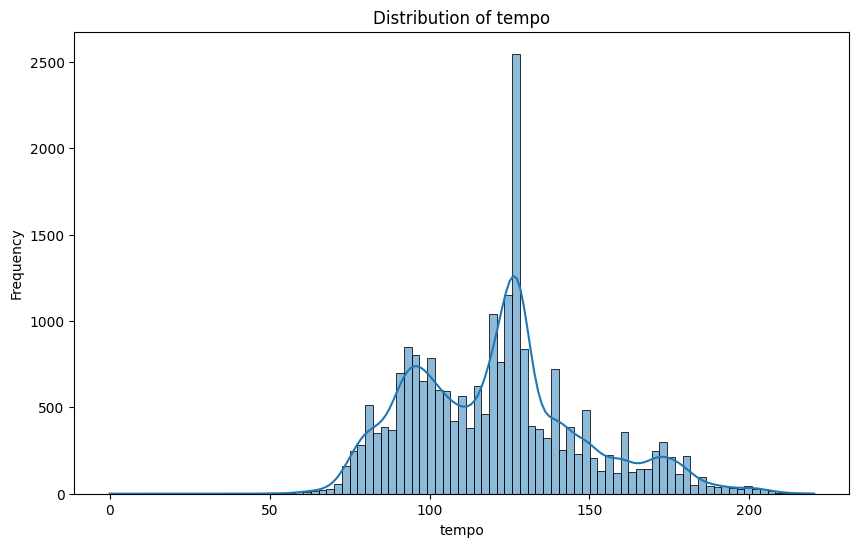

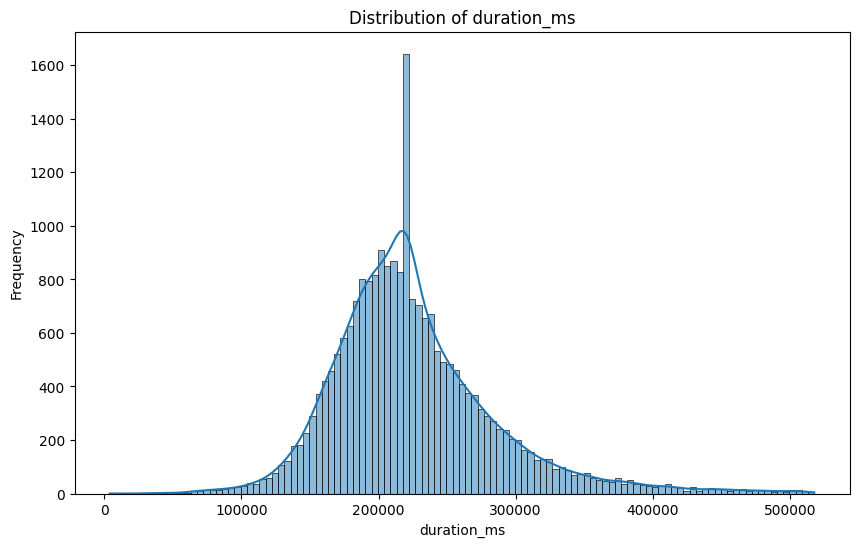

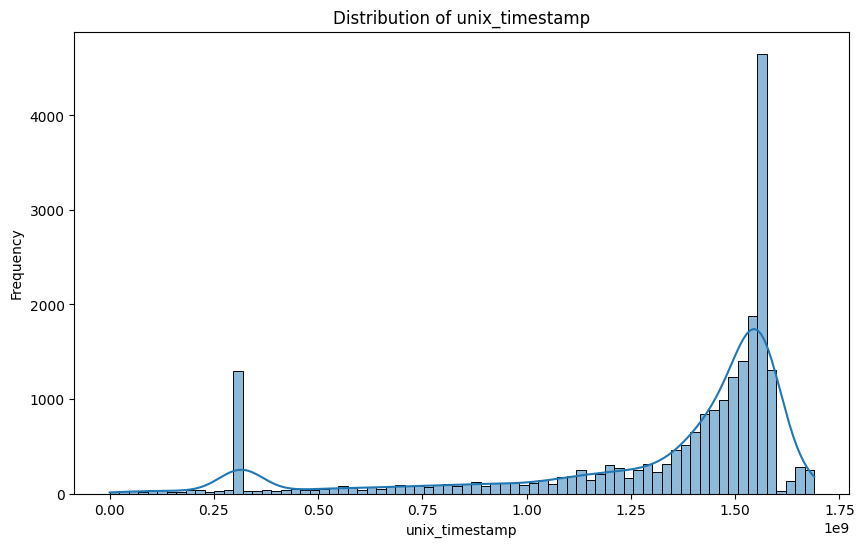

In [ ]:
for col in df_cleaned.columns:
    plt.figure(figsize=(10, 6))
    sns.histplot(df_cleaned[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

In [ ]:
skewed = ['speechiness', 'acousticness', 'liveness', 'tempo', 'duration_ms', 'instrumentalness']
# df_cleaned['loudness'] = abs(df_cleaned['loudness'].min()) + df_cleaned['loudness']
for label in skewed:
    if label in df_cleaned.columns:
        skewness = df_cleaned[label].skew()

        while abs(skewness) > .5:
            df_cleaned[label] = np.log1p(df_cleaned[label])
            skewness = df_cleaned[label].skew()

In [ ]:
df_cleaned.to_csv('df_cleaned.csv', index=False)
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22413 entries, 0 to 22412
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   popular           22413 non-null  int64  
 1   playlist_genre    22413 non-null  int64  
 2   danceability      22413 non-null  float64
 3   energy            22413 non-null  float64
 4   key               22413 non-null  float64
 5   loudness          22413 non-null  float64
 6   mode              22413 non-null  int64  
 7   speechiness       22413 non-null  float64
 8   acousticness      22413 non-null  float64
 9   instrumentalness  22413 non-null  float64
 10  liveness          22413 non-null  float64
 11  valence           22413 non-null  float64
 12  tempo             22413 non-null  float64
 13  duration_ms       22413 non-null  float64
 14  unix_timestamp    22413 non-null  float64
dtypes: float64(12), int64(3)
memory usage: 2.6 MB


# Neural network

## Part 2a

We need to optimize (tp * 150000) + (fp * 20000) - (tp + fp) * 30000.

## "Random" NN settings before grid tuning

Fitting 3 folds for each of 1 candidates, totalling 3 fits


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


Best Hyperparameters:  {'activation_function': 'relu', 'dropout_rate': 0.4, 'num_layers': 2, 'num_neurons': 64, 'optimizer': 'adam'}
Optimal cutoff threshold: 0.11800000000000001


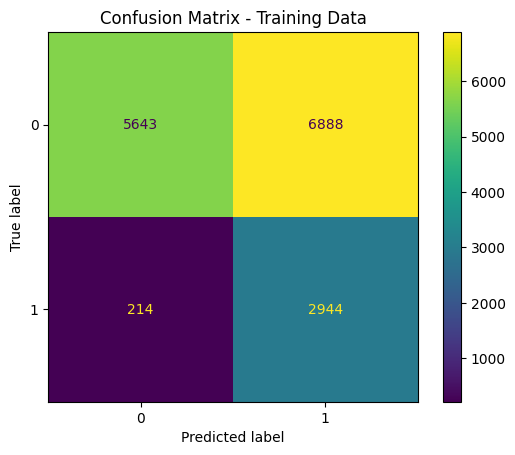

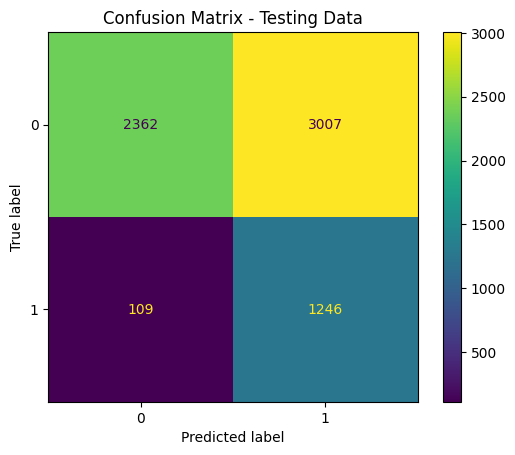

Profit: 119450000


In [ ]:
def create_model(optimizer='adam', activation_function='relu', dropout_rate=0.4, num_layers=2, num_neurons=64):
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1],)))
    model.add(Dense(num_neurons, activation=activation_function))
    model.add(Dropout(dropout_rate))

    for _ in range(num_layers - 1):
        model.add(Dense(num_neurons // 2, activation=activation_function))
        model.add(Dropout(dropout_rate))

    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizer)
    return model

def calculate_profit_metric(y_true, y_pred_probs):
    best_cutoff = 0.5
    best_profit = -np.inf
    cutoffs = np.arange(0, 1, 0.01)

    for cutoff in cutoffs:
        y_pred = (y_pred_probs > cutoff).astype(float)
        tp = np.sum((y_true == 1) & (y_pred == 1))
        fp = np.sum((y_true == 0) & (y_pred == 1))
        profit = (tp * 150000) + (fp * 20000) - (tp + fp) * 30000
        if profit > best_profit:
            best_cutoff = cutoff
            best_profit = profit

    return best_profit

def profit_scorer(y_true, y_pred_probs):
    return calculate_profit_metric(y_true, y_pred_probs)

scorer = make_scorer(profit_scorer, needs_proba=True, greater_is_better=True)

y = df_cleaned['popular']
X = df_cleaned.drop('popular', axis=1)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=528)

param_grid = {
    'optimizer': ['adam'],
    'activation_function': ['relu'],
    'dropout_rate': [0.4],
    'num_layers': [2],
    'num_neurons': [64],
}

tuned_model = KerasClassifier(
    model=create_model,
    epochs=50,
    batch_size=32,
    optimizer='adam',
    activation_function='relu',
    dropout_rate=0.4,
    num_layers=2,
    num_neurons=64,
    verbose=0
)

grid = GridSearchCV(estimator=tuned_model, param_grid=param_grid, cv=3, scoring=scorer, verbose=2, n_jobs=-1)
grid_result = grid.fit(X_train, y_train)

best_params = grid_result.best_params_
print("Best Hyperparameters: ", best_params)

best_model = grid_result.best_estimator_

y_train_probs = best_model.predict_proba(X_train)[:, 1]
y_test_probs = best_model.predict_proba(X_test)[:, 1]

best_cutoff = 0.5
best_profit = -np.inf
cutoffs = np.arange(0, 1, 0.001)

for cutoff in cutoffs:
    y_train_pred = (y_train_probs > cutoff).astype(int)
    cm = confusion_matrix(y_train, y_train_pred)
    tp = cm[1, 1]
    fp = cm[0, 1]
    profit = (tp * 150000) + (fp * 20000) - (tp + fp) * 30000
    if profit > best_profit:
        best_profit = profit
        best_cutoff = cutoff

print(f"Optimal cutoff threshold: {best_cutoff}")

y_train_pred = (y_train_probs > best_cutoff).astype(int)
y_test_pred = (y_test_probs > best_cutoff).astype(int)

train_cm = confusion_matrix(y_train, y_train_pred)
test_cm = confusion_matrix(y_test, y_test_pred)

ConfusionMatrixDisplay(train_cm).plot()
plt.title("Confusion Matrix - Training Data")
plt.show()

ConfusionMatrixDisplay(test_cm).plot()
plt.title("Confusion Matrix - Testing Data")
plt.show()

print('Profit:', (test_cm[1][1] * 150000) + (test_cm[0][1] * 20000) - (test_cm[1][1] + test_cm[0][1]) * 30000)

## NN's grid tuning

Fitting 3 folds for each of 108 candidates, totalling 324 fits


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best Hyperparameters:  {'activation_function': 'tanh', 'dropout_rate': 0.2, 'num_layers': 3, 'num_neurons': 64, 'optimizer': 'sgd'}
Optimal cutoff threshold: 0.075


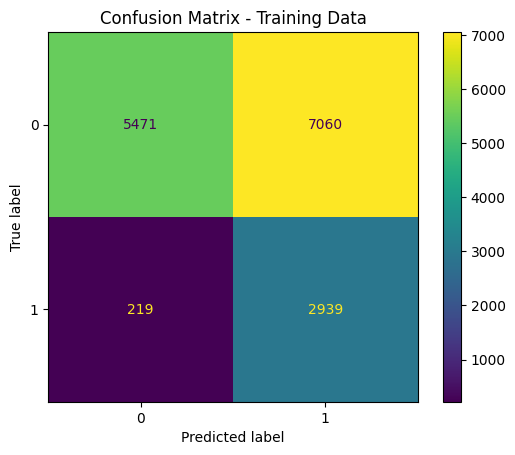

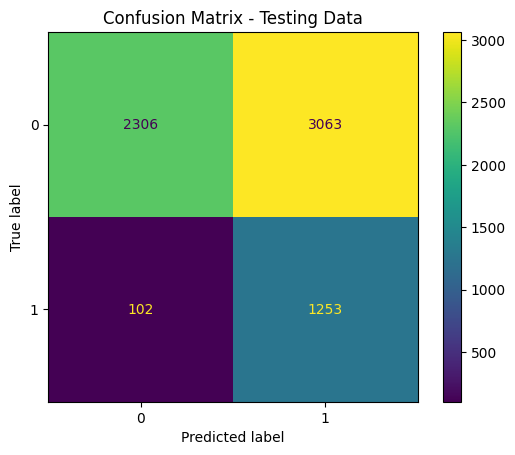

Profit: 119730000


In [ ]:
param_grid = {
    'optimizer': ['adam', 'rmsprop', 'sgd'],
    'activation_function': ['relu', 'tanh'],
    'dropout_rate': [0.2, 0.4, 0.6],
    'num_layers': [1, 2, 3],
    'num_neurons': [32, 64],
}

tuned_model = KerasClassifier(
    model=create_model,
    epochs=50,
    batch_size=32,
    optimizer='adam',
    activation_function='relu',
    dropout_rate=0.4,
    num_layers=2,
    num_neurons=64,
    verbose=0
)

grid = GridSearchCV(estimator=tuned_model, param_grid=param_grid, cv=3, scoring=scorer, verbose=2, n_jobs=-1)
grid_result = grid.fit(X_train, y_train)

best_params = grid_result.best_params_
print("Best Hyperparameters: ", best_params)

best_model = grid_result.best_estimator_

y_train_probs = best_model.predict_proba(X_train)[:, 1]
y_test_probs = best_model.predict_proba(X_test)[:, 1]

best_cutoff = 0.5
best_profit = -np.inf
cutoffs = np.arange(0, 1, 0.001)

for cutoff in cutoffs:
    y_train_pred = (y_train_probs > cutoff).astype(int)
    cm = confusion_matrix(y_train, y_train_pred)
    tp = cm[1, 1]
    fp = cm[0, 1]
    profit = (tp * 150000) + (fp * 20000) - (tp + fp) * 30000
    if profit > best_profit:
        best_profit = profit
        best_cutoff = cutoff

print(f"Optimal cutoff threshold: {best_cutoff}")

y_train_pred = (y_train_probs > best_cutoff).astype(int)
y_test_pred = (y_test_probs > best_cutoff).astype(int)

train_cm = confusion_matrix(y_train, y_train_pred)
test_cm = confusion_matrix(y_test, y_test_pred)

ConfusionMatrixDisplay(train_cm).plot()
plt.title("Confusion Matrix - Training Data")
plt.show()

ConfusionMatrixDisplay(test_cm).plot()
plt.title("Confusion Matrix - Testing Data")
plt.show()

print('Profit:', (test_cm[1][1] * 150000) + (test_cm[0][1] * 20000) - (test_cm[1][1] + test_cm[0][1]) * 30000)

## Part 2b

We need to optimize (tp * 150000) + (fp * (0.2 * 150000 + 0.8 * 20000)) - (tp + fp) * 30000

Fitting 3 folds for each of 108 candidates, totalling 324 fits


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best Hyperparameters:  {'activation_function': 'relu', 'dropout_rate': 0.2, 'num_layers': 1, 'num_neurons': 32, 'optimizer': 'adam'}
Optimal cutoff threshold: 0.0


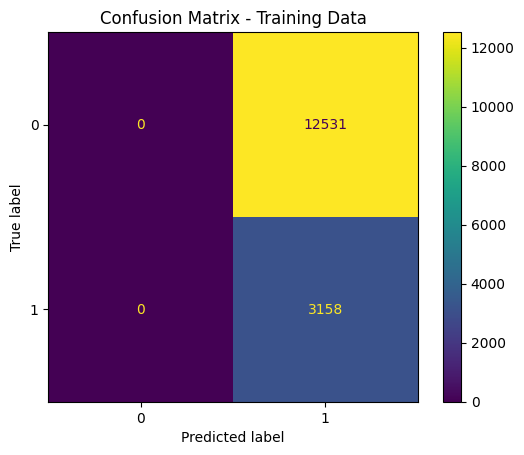

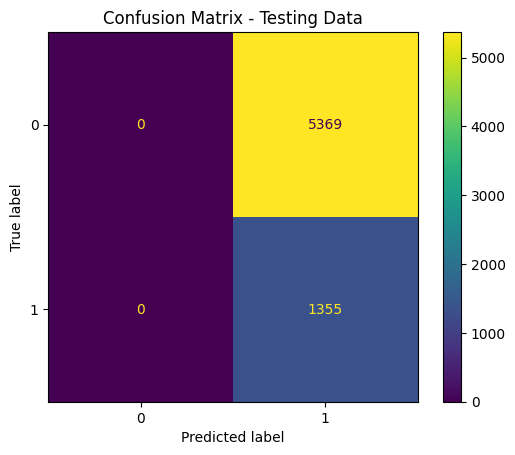

Profit: 248504000.0


In [ ]:
def calculate_profit_metric(y_true, y_pred_probs):
    best_cutoff = 0.5
    best_profit = -np.inf
    cutoffs = np.arange(0, 1, 0.01)

    for cutoff in cutoffs:
        y_pred = (y_pred_probs > cutoff).astype(float)
        tp = np.sum((y_true == 1) & (y_pred == 1))
        fp = np.sum((y_true == 0) & (y_pred == 1))
        profit = (tp * 150000) + (fp * (0.2 * 150000 + 0.8 * 20000)) - (tp + fp) * 30000
        if profit > best_profit:
            best_cutoff = cutoff
            best_profit = profit

    return best_profit

def profit_scorer(y_true, y_pred_probs):
    return calculate_profit_metric(y_true, y_pred_probs)

scorer = make_scorer(profit_scorer, needs_proba=True, greater_is_better=True)

tuned_model = KerasClassifier(
    model=create_model,
    epochs=50,
    batch_size=32,
    optimizer='adam',
    activation_function='relu',
    dropout_rate=0.4,
    num_layers=2,
    num_neurons=64,
    verbose=0
)

grid = GridSearchCV(estimator=tuned_model, param_grid=param_grid, cv=3, scoring=scorer, verbose=2, n_jobs=-1)
grid_result = grid.fit(X_train, y_train)

best_params = grid_result.best_params_
print("Best Hyperparameters: ", best_params)

best_model = grid_result.best_estimator_

y_train_probs = best_model.predict_proba(X_train)[:, 1]
y_test_probs = best_model.predict_proba(X_test)[:, 1]

best_cutoff = 0.5
best_profit = -np.inf
cutoffs = np.arange(0, 1, 0.001)

for cutoff in cutoffs:
    y_train_pred = (y_train_probs > cutoff).astype(int)
    cm = confusion_matrix(y_train, y_train_pred)
    tp = cm[1, 1]
    fp = cm[0, 1]
    profit = (tp * 150000) + (fp * (0.2 * 150000 + 0.8 * 20000)) - (tp + fp) * 30000
    if profit > best_profit:
        best_profit = profit
        best_cutoff = cutoff

y_train_pred = (y_train_probs > best_cutoff).astype(int)
y_test_pred = (y_test_probs > best_cutoff).astype(int)

print(f"Optimal cutoff threshold: {best_cutoff}")

train_cm = confusion_matrix(y_train, y_train_pred)
test_cm = confusion_matrix(y_test, y_test_pred)

ConfusionMatrixDisplay(train_cm).plot()
plt.title("Confusion Matrix - Training Data")
plt.show()

ConfusionMatrixDisplay(test_cm).plot()
plt.title("Confusion Matrix - Testing Data")
plt.show()

print('Profit:', (test_cm[1][1] * 150000) + (test_cm[0][1] * (0.2 * 150000 + 0.8 * 20000)) - (test_cm[1][1] + test_cm[0][1]) * 30000)


This result indicates that we should invest in the entire market, which is reasonable given the possibility of the track gaining popularity:

In [ ]:
df_1[df_1['popular'] == 1].shape[0] / df_1.shape[0]

0.21792431279981725